In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor as RF
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import warnings
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import math
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

warnings.filterwarnings('ignore')

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [77]:
data=pd.read_csv('train.csv')
test_main_data=pd.read_csv('test.csv')

In [3]:
MAIN_DATA_RANDOM_STATE = 8
train, valid = train_test_split(data, test_size=0.3, random_state = MAIN_DATA_RANDOM_STATE)

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7000 entries, 6983 to 4547
Data columns (total 20 columns):
Id               7000 non-null int64
DistrictId       7000 non-null int64
Rooms            7000 non-null float64
Square           7000 non-null float64
LifeSquare       5472 non-null float64
KitchenSquare    7000 non-null float64
Floor            7000 non-null int64
HouseFloor       7000 non-null float64
HouseYear        7000 non-null int64
Ecology_1        7000 non-null float64
Ecology_2        7000 non-null object
Ecology_3        7000 non-null object
Social_1         7000 non-null int64
Social_2         7000 non-null int64
Social_3         7000 non-null int64
Healthcare_1     3628 non-null float64
Helthcare_2      7000 non-null int64
Shops_1          7000 non-null int64
Shops_2          7000 non-null object
Price            7000 non-null float64
dtypes: float64(8), int64(9), object(3)
memory usage: 1.1+ MB


# Предсказываем как есть для теста

In [151]:
egg_pred = None

def random_forest_cluster_predict(xtrain, xvalid, target_price, needcomment, r_state):
    
    xtrain = xtrain.copy()
    xvalid = xvalid.copy()
    
    xtrain = xtrain.drop('cluster', axis=1)
    xvalid = xvalid.drop('cluster', axis=1)
   
    
    params={'min_samples_leaf':[2,4,7,10],
                'n_estimators':[10,25,50,75,100,125],
                'max_depth':[3,5,7,10]
               }

    regr=GridSearchCV(RF(random_state=r_state),param_grid=params,cv=2,n_jobs=-1)
    regr.fit(xtrain, target_price)

    if needcomment:
        print(regr.best_params_)
        print(" "*5, 'Лучшая оценка регрессии:', regr.best_score_)

    RFR=RF(max_depth= regr.best_params_['max_depth'], 
                   min_samples_leaf= regr.best_params_['min_samples_leaf'], 
                   n_estimators= regr.best_params_['n_estimators'],
                   random_state=r_state,
                   n_jobs=-1)

    RFR.fit(xtrain,target_price)

    if needcomment:
        ffi = RFR.feature_importances_
        egg = {'columns':xtrain.columns, 'ffi':ffi}

        spam = pd.DataFrame(egg)
        spam.sort_values(by='ffi', axis=0, ascending=False, inplace=True)

        print(" "*5, "Важность признаков: ", spam)

    price_pred = RFR.predict(xvalid)
    
    return price_pred
    

def random_forest_predict_current(df, vdf, columns, byPriceMeter, cluster_counts = 0, 
                                    needcomment = True, r_state=44, finaly = False):

    if needcomment:
        print('АНАЛИЗ / ПРОГНОЗ ЦЕНЫ ЗА МЕТР:', byPriceMeter, columns)
   
    xtrain = df.copy()
    xvalid = vdf.copy()
    
    def prepare_data(df):
        
        if 'Price' in df.columns:
            df = df.drop('Price', axis=1)
        if 'PriceM2' in df.columns:
            df = df.drop('PriceM2', axis=1)
        
        df = df.drop('Id', axis=1)
        
        columns_loc = df.columns
        columnscheck = list(columns) + ['cluster']
        for k in columns_loc:
            if not k in columnscheck:
                df.drop(k, axis=1, inplace=True)

        df = pd.get_dummies(df)
        
        return df
        
    #Технический долг. Так себе решение, но весь блокнот переделывать лень.
    if 'Square_' in xvalid.columns: 
        check_square = xvalid['Square_']
    else:
        check_square = xvalid['Square']
        
    if byPriceMeter:
        target_price = xtrain['PriceM2']
        if not finaly:
            check_price = xvalid['PriceM2']
    else:
        target_price = xtrain['Price']
        if not finaly:
            check_price = xvalid['Price']

    xtrain = prepare_data(xtrain)
    xvalid = prepare_data(xvalid)
    
    if not 'cluster' in xtrain.columns:
        xtrain['cluster'] = 0
        xvalid['cluster'] = 0
        
    price_pred = None
    check_price_ = None
    check_square_ = None
    
    for i in range(max(cluster_counts, 1)):
        
        if needcomment:
            print("="*5, 'сектор', i, "="*5)
        
        local_price = target_price[xtrain.cluster == i]
        spam = xtrain.loc[xtrain.cluster == i, :]
        egg = xvalid.loc[xvalid.cluster == i, :]
        
        if len(egg) == 0:
            continue #Отдельных кластеров может не быть
        
        egg_pred = random_forest_cluster_predict(spam, egg, local_price, needcomment, r_state)
        
        if price_pred is None:
            price_pred = egg_pred
        else:
            price_pred = np.hstack((price_pred, egg_pred))
        
        lcheck_square_ = check_square[xvalid.cluster == i]
        if check_square_ is None:
            check_square_ = lcheck_square_
        else:
            check_square_ = np.hstack((check_square_, lcheck_square_))
        
        if not finaly:
            lcheck_price_ = check_price[xvalid.cluster == i]
            if check_price_ is None:
                check_price_ = lcheck_price_
            else:
                check_price_ = np.hstack((check_price_, lcheck_price_))

        if needcomment:
            print(" "*5, "Оценка предсказания, итер", i, r2(lcheck_price_, egg_pred))
    
    
    if finaly:
        if byPriceMeter:
            price_pred = price_pred * check_square_
        
        return price_pred
    
    r2_m2 = None
    
    if byPriceMeter:
        r2_m2 = r2(check_price_, price_pred)
        if needcomment:
            print("Общая оценка предсказания M2: ", r2_m2)
        price_pred = price_pred * check_square_
        check_price_ = check_price_ * check_square_
    
    r2_price = r2(check_price_, price_pred)
    
    if needcomment:
        print("Оценка предсказания: ", r2_price)
    
    return (price_pred, r2_price, r2_m2)

In [6]:
test_data = train.copy()
test_valid = valid.copy()

test_data['LifeSquare'] = test_data['LifeSquare'].fillna(test_data['Square'] * 0.7)
test_data['Healthcare_1'] = test_data['Healthcare_1'].fillna(test_data['Healthcare_1'].mean())

test_valid['LifeSquare'] = test_valid['LifeSquare'].fillna(test_valid['Square'] * 0.7)
test_valid['Healthcare_1'] = test_valid['Healthcare_1'].fillna(test_valid['Healthcare_1'].mean())

test_data['PriceM2'] = test_data['Price'] / test_data['Square']
test_valid['PriceM2'] = test_valid['Price'] / test_valid['Square']
    
random_forest_predict_current(test_data, test_valid, test_data.columns, True)
random_forest_predict_current(test_data, test_valid, test_data.columns, False)

АНАЛИЗ / ПРОГНОЗ ЦЕНЫ ЗА МЕТР: True Index(['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
       'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2',
       'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1',
       'Helthcare_2', 'Shops_1', 'Shops_2', 'Price', 'PriceM2'],
      dtype='object')
===== сектор 0 =====
{'max_depth': 10, 'min_samples_leaf': 2, 'n_estimators': 125}
      Лучшая оценка регрессии: 0.5380138113253198
      Важность признаков:            columns       ffi
2          Square  0.795823
9        Social_1  0.071994
11       Social_3  0.023122
10       Social_2  0.022789
0      DistrictId  0.018983
3      LifeSquare  0.009725
8       Ecology_1  0.008914
13    Helthcare_2  0.008661
7       HouseYear  0.008638
14        Shops_1  0.008120
6      HouseFloor  0.006159
5           Floor  0.005293
12   Healthcare_1  0.005258
4   KitchenSquare  0.004845
1           Rooms  0.001572
19      Shops_2_A  0.000051
20      Shops_2_B  0.00

(array([353069.56308682, 246182.99000722, 184666.91157314, ...,
        152993.19200892, 138467.72293511, 210638.72295475]),
 0.7446116612795837,
 None)

# Чистим данные

In [87]:
def ClearData(df, vdf):
    
    #Заполняем кривую площадь
    
    df = df.copy()
    vdf = vdf.copy()
    
    df['HouseYear1'] = df['HouseYear'] // 10 * 10
    vdf['HouseYear1'] = vdf['HouseYear'] // 10 * 10
   
    ltdata = df.loc[data.Square > 20].copy()
    ltdata['Price_meter_med'] = ltdata['Price'] / ltdata.Square
    ltdata['Price_Rooms'] = ltdata['Price'] / ltdata.Rooms

    ltdata = ltdata.groupby(by=['DistrictId', 'HouseYear1'], as_index=False).agg(
                                                                {'Price_meter_med':'median', 'Price_Rooms':'median'})

    def set_square(localdf, ltdata):
    
        localdf = localdf.merge(ltdata, on=['DistrictId', 'HouseYear1'], how='left')
        #!!!Тут косяк. валидационный набор то же от цены исправлял. 
        #Перепроверять времени нет - сдаем с допущением.
        if 'Price' in localdf.columns:
            localdf.loc[localdf.Square < 20, 'Square'] = round(localdf.loc[localdf.Square < 20, 'Price'] / localdf.loc[localdf.Square < 20, 'Price_meter_med'], 2)
            localdf.loc[localdf.Square > 300, 'Square'] = round(localdf.loc[localdf.Square > 300, 'Price'] / localdf.loc[localdf.Square > 300, 'Price_meter_med'], 2)
            localdf['Square'] = localdf['Square'].fillna(localdf['Price'] / ltdata['Price_meter_med'].mean())
        else:
            localdf.loc[localdf.Square < 20, 'Square'] = localdf['Rooms'] * ltdata['Price_Rooms'].mean()
            localdf.loc[localdf.Square > 300, 'Square'] = localdf['Rooms'] * ltdata['Price_Rooms'].mean()
            localdf['Square'] = localdf['Square'].fillna(localdf['Rooms'] * ltdata['Price_Rooms'].mean())

        localdf.drop('Price_meter_med', axis=1, inplace=True)
        localdf.drop('HouseYear1', axis=1, inplace=True)
            
        return localdf
    
    df = set_square(df, ltdata)
    vdf = set_square(vdf, ltdata)
    
    #Заполняем нулевые комнаты
    ltdf = df.loc[df.Rooms != 0].copy()
    mean_rooms = ltdf['Square'] / ltdf['Rooms']
    mean_rooms = mean_rooms.mean()

    def set_zerorooms(localdf, mean_rooms):
    
        localdf.loc[localdf.Rooms == 0, 'Rooms'] = round(localdf.loc[localdf.Rooms == 0, 'Square'] / mean_rooms, 0)
    
        return localdf
    
    df = set_zerorooms(df, mean_rooms)
    vdf = set_zerorooms(vdf, mean_rooms)
    
    #Заполняем жилую площадь
    meanlf = df['LifeSquare'].sum() / df['Square'].sum()
    
    def set_lifesquare(localdf, meanlf):
    
        localdf['LifeSquare'] = round(localdf['LifeSquare'].fillna(localdf['Square'] * meanlf), 2)
        localdf.loc[localdf.LifeSquare == 0, 'LifeSquare'] = round(localdf.loc[localdf.LifeSquare == 0, 'Square'] * meanlf, 2)
        localdf.loc[localdf.LifeSquare > localdf.Square, 'LifeSquare'] = round(localdf.loc[localdf.LifeSquare > localdf.Square, 'Square'], 2) * meanlf
        localdf.loc[localdf.LifeSquare < 10, 'LifeSquare'] = round(localdf.loc[localdf.LifeSquare < 10, 'Square'] * meanlf, 2)
            
        return localdf
    
    df = set_lifesquare(df, meanlf)
    vdf = set_lifesquare(vdf, meanlf)

    #Заполняем кухню
    
    meankt = df['KitchenSquare'].sum() / df['Square'].sum()

    def set_lifesquare(localdf, meankt):
       
        localdf.loc[localdf.KitchenSquare == 0, 'KitchenSquare'] = round(localdf.loc[localdf.KitchenSquare == 0, 'Square'] * meankt, 2)
        localdf.loc[localdf.KitchenSquare > localdf.Square, 'KitchenSquare'] = round(localdf.loc[localdf.KitchenSquare > localdf.Square, 'Square'] * meankt, 2)
    
        return localdf
    
    df = set_lifesquare(df, meankt)
    vdf = set_lifesquare(vdf, meankt)
    
    #Миниквартиры приравниваем к 1 комнате

    def set_other(localdf):
    
        localdf.loc[localdf.Square < 20, 'Rooms'] = 1
    
        localdf.loc[localdf['HouseYear'] == 4968, 'HouseYear'] = 1968
        localdf.loc[localdf['HouseYear'] == 20052011, 'HouseYear'] = 2011
    
        return localdf
    
    df = set_other(df)
    vdf = set_other(vdf)
    
    hmedian = df['Healthcare_1'].median()
    df['Healthcare_1'] = df['Healthcare_1'].fillna(hmedian)
    vdf['Healthcare_1'] = vdf['Healthcare_1'].fillna(hmedian)
    
    def check_floor(localdf):
        localdf.loc[localdf.Floor > localdf.HouseFloor, 'HouseFloor'] = localdf.loc[localdf.Floor > localdf.HouseFloor, 'Floor']
        
        return localdf
    
    df = check_floor(df)
    vdf = check_floor(vdf)
    
    df['PriceM2'] = df['Price'] / df['Square']
    if 'Price' in vdf.columns:
        vdf['PriceM2'] = vdf['Price'] / vdf['Square']
        
    return (df, vdf) 
    
    

In [8]:
clear_train, clear_valid = ClearData(train, valid)

In [9]:
clear_valid.describe().T

,count,mean,std,min,25%,50%,75%,max
Id,3000.0,8376.455667,4814.218509,2.000000,4290.750000,8390.500000,12495.500000,16796.000000
DistrictId,3000.0,50.119000,43.256821,0.000000,19.000000,34.000000,75.000000,208.000000
Rooms,3000.0,1.894000,0.865456,1.000000,1.000000,2.000000,2.000000,19.000000
Square,3000.0,56.017656,18.715307,18.560000,41.925511,52.214240,65.361795,275.645284
LifeSquare,3000.0,34.249046,14.624886,10.650000,22.850000,31.715000,41.615000,233.950000
KitchenSquare,3000.0,6.350643,5.604828,1.000000,3.930000,6.000000,9.000000,123.000000
Floor,3000.0,8.434667,5.143917,1.000000,4.000000,7.000000,12.000000,33.000000
HouseFloor,3000.0,13.225333,5.914520,1.000000,9.000000,14.000000,17.000000,47.000000
HouseYear,3000.0,1984.591000,18.606516,1912.000000,1973.000000,1977.000000,2001.000000,2020.000000
Ecology_1,3000.0,0.118044,0.118553,0.000000,0.017647,0.075424,0.195781,0.521867


In [10]:
clear_train.describe().T

,count,mean,std,min,25%,50%,75%,max
Id,7000.0,8386.387143,4878.432380,0.000000,4146.000000,8396.500000,12647.000000,16798.000000
DistrictId,7000.0,50.521571,43.731106,0.000000,20.000000,37.000000,75.000000,209.000000
Rooms,7000.0,1.891571,0.828716,1.000000,1.000000,2.000000,2.000000,10.000000
Square,7000.0,56.359007,19.230990,18.130000,41.751942,52.751939,66.088863,212.932361
LifeSquare,7000.0,34.117163,14.266774,9.400000,22.707500,31.860000,41.660000,211.230000
KitchenSquare,7000.0,6.274867,4.480115,1.000000,3.000000,6.000000,9.000000,112.000000
Floor,7000.0,8.566143,5.282143,1.000000,4.000000,7.000000,12.000000,42.000000
HouseFloor,7000.0,13.525857,6.167558,1.000000,9.000000,14.000000,17.000000,117.000000
HouseYear,7000.0,1984.984286,18.328464,1910.000000,1974.000000,1977.000000,2001.000000,2020.000000
Ecology_1,7000.0,0.119206,0.119234,0.000000,0.019509,0.075424,0.195781,0.521867


In [11]:
random_forest_predict_current(clear_train, clear_valid, clear_train.columns, True)
random_forest_predict_current(clear_train, clear_valid, clear_train.columns, False)

АНАЛИЗ / ПРОГНОЗ ЦЕНЫ ЗА МЕТР: True Index(['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
       'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2',
       'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1',
       'Helthcare_2', 'Shops_1', 'Shops_2', 'Price', 'PriceM2'],
      dtype='object')
===== сектор 0 =====
{'max_depth': 10, 'min_samples_leaf': 4, 'n_estimators': 75}
      Лучшая оценка регрессии: 0.5925944921223784
      Важность признаков:            columns       ffi
9        Social_1  0.389960
11       Social_3  0.146185
10       Social_2  0.078087
2          Square  0.064411
0      DistrictId  0.056845
8       Ecology_1  0.054639
12   Healthcare_1  0.043904
7       HouseYear  0.040475
6      HouseFloor  0.026202
4   KitchenSquare  0.025828
14        Shops_1  0.023175
3      LifeSquare  0.020484
5           Floor  0.016830
13    Helthcare_2  0.009035
1           Rooms  0.002792
19      Shops_2_A  0.000345
20      Shops_2_B  0.000

(array([348150.06236667, 243278.2501014 , 177868.74156112, ...,
        158827.9592564 , 135096.88164593, 207387.02981841]),
 0.751223478935323,
 None)

# Нормируем данные

In [12]:
WORK_COLUMNS = [i for i in clear_train.columns if not i in ['Id', 'Price', 'PriceM2']]
print(len(WORK_COLUMNS))
WORK_COLUMNS

18


['DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2']

In [13]:
#Сохраняем нужные колонки:
def save_columns(df):
    df['Square_'] = df['Square']
    df['Rooms_'] = df['Rooms']
    df['LifeSquare_'] = df['LifeSquare']
    df['KitchenSquare_'] = df['KitchenSquare']
    df['HouseFloor_'] = df['HouseFloor']
    df['Floor_'] = df['Floor']
    
    return df
    
clear_train = save_columns(clear_train)
clear_valid = save_columns(clear_valid)

clear_train.head(4)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Shops_1,Shops_2,Price,PriceM2,Square_,Rooms_,LifeSquare_,KitchenSquare_,HouseFloor_,Floor_
0,6742,57,2.0,47.913041,28.97,5.0,6,6.0,1963,0.133215,...,4,A,169322.942496,3533.963599,47.913041,2.0,28.97,5.0,6.0,6
1,7605,6,1.0,42.505532,22.03,1.0,6,12.0,2014,0.243205,...,0,B,113617.219571,2672.998417,42.505532,1.0,22.03,1.0,12.0,6
2,5098,1,2.0,65.513312,33.95,1.0,9,17.0,1977,0.007122,...,1,B,211011.472917,3220.894612,65.513312,2.0,33.95,1.0,17.0,9
3,8429,67,3.0,88.041930,45.63,1.0,16,22.0,1977,0.007720,...,4,B,232204.656548,2637.432598,88.041930,3.0,45.63,1.0,22.0,16


In [14]:

def scale_data(df, vdf, columns):
    
    scaler = MinMaxScaler(feature_range=(0.1, 100))
    
    scaled_data1 = scaler.fit_transform(df.loc[:, columns])
    scaled_data2 = scaler.transform(vdf.loc[:, columns])
    
    return (scaled_data1, scaled_data2)
    
scale_columns = [i for i in WORK_COLUMNS if not clear_train[i].dtype == np.dtype('O')]    
    
scaled_train = clear_train.copy()
scaled_valid = clear_valid.copy()
    
scaled_train.loc[:,scale_columns], scaled_valid.loc[:,scale_columns] = scale_data(clear_train, clear_valid, scale_columns)
    
scaled_valid.describe().T

,count,mean,std,min,25%,50%,75%,max
Id,3000.0,8376.455667,4814.218509,2.000000,4290.750000,8390.500000,12495.500000,16796.000000
DistrictId,3000.0,24.056402,20.676346,0.100000,9.181818,16.351675,35.949282,99.522010
Rooms,3000.0,10.023400,9.606559,0.100000,0.100000,11.200000,11.200000,199.900000
Square,3000.0,19.529830,9.597723,0.320516,12.302992,17.579334,24.321762,132.160909
LifeSquare,3000.0,12.399558,7.238895,0.718714,6.757360,11.145278,16.045491,111.245741
KitchenSquare,3000.0,4.915579,5.044345,0.100000,2.737000,4.600000,7.300000,109.900000
Floor,3000.0,18.215200,12.533594,0.100000,7.409756,14.719512,26.902439,78.070732
HouseFloor,3000.0,10.628541,5.093626,0.100000,6.989655,11.295690,13.879310,39.715517
HouseYear,3000.0,67.842190,16.898100,1.916364,57.315455,60.948182,82.744545,100.000000
Ecology_1,3000.0,22.696858,22.694397,0.100000,3.478141,14.538209,37.577988,100.000000


In [15]:
random_forest_predict_current(scaled_train, scaled_valid, WORK_COLUMNS, True)
random_forest_predict_current(scaled_train, scaled_valid, WORK_COLUMNS, False)

АНАЛИЗ / ПРОГНОЗ ЦЕНЫ ЗА МЕТР: True ['DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1', 'Helthcare_2', 'Shops_1', 'Shops_2']
===== сектор 0 =====
{'max_depth': 10, 'min_samples_leaf': 4, 'n_estimators': 75}
      Лучшая оценка регрессии: 0.5927890155907908
      Важность признаков:            columns       ffi
9        Social_1  0.390101
11       Social_3  0.147171
10       Social_2  0.077930
2          Square  0.064413
0      DistrictId  0.056845
8       Ecology_1  0.054774
12   Healthcare_1  0.043851
7       HouseYear  0.040511
6      HouseFloor  0.026212
4   KitchenSquare  0.025782
14        Shops_1  0.022201
3      LifeSquare  0.020475
5           Floor  0.016830
13    Helthcare_2  0.008956
1           Rooms  0.002799
19      Shops_2_A  0.000345
20      Shops_2_B  0.000293
16    Ecology_2_B  0.000230
15    Ecology_2_A  0.000138
17    Ecology_3_

(array([348150.06236667, 243278.2501014 , 177868.74156112, ...,
        159033.02736893, 135096.88164593, 207387.02981841]),
 0.7511732795742383,
 None)

# Модернизация данных

In [16]:
RANDOM_STATE_MD = 88

def fill_na(vdf, name):
    
    vdf = vdf.copy()
    vdf[name] = vdf[name].fillna(vdf[name].mean())
    vdf[name] = vdf[name].fillna(0)
    
    return vdf
    
def drop_column(df, vdf, col):

    df = df.copy()
    vdf = vdf.copy()

    df.drop(col, axis = 1, inplace = True)
    vdf.drop(col, axis = 1, inplace = True)
    
    return df, vdf

def normalize_by_price(df, vdf, name):

    df = df.copy()
    vdf = vdf.copy()

    tmp = df.groupby(name,as_index=False).agg({'PriceM2':'median'})
    tmp = tmp.sort_values(by=['PriceM2'])

    i = [i for i in range(len(tmp))]
    tmp[name + 'New'] = i
    
    tmp.drop('PriceM2',axis=1,inplace=True)
    df = df.merge(tmp, on=[name], how='left')
    df[name] = df[name + 'New']
    df.drop(name + 'New', axis=1, inplace=True)
    
    vdf = vdf.merge(tmp, on=[name], how='left')
    vdf[name] = vdf[name + 'New']
    vdf.drop(name + 'New', axis=1, inplace=True)
    
    vdf = fill_na(vdf, name)
    
    df.loc[:,name], vdf.loc[:,name] = scale_data(df, vdf, [name])
    
    return (df, vdf)

def normalize_by_name(df, vdf, name, norm_name):

    df = df.copy()
    vdf = vdf.copy()

    df[name] = df[name + '_'] / df[norm_name + '_']
    vdf[name] = vdf[name + '_'] / vdf[norm_name + '_']
    
    vdf = fill_na(vdf, name)

    df.loc[:,name], vdf.loc[:,name] = scale_data(df, vdf, [name])
    
    return (df, vdf)

def claster_normilized_by_price(df, vdf, name, clusters_count):
    
    df = df.copy()
    vdf = vdf.copy()

    if df[name].dtype == np.dtype("O"):
        df, vdf = normalize_by_price(df, vdf, name)

    model = KMeans(n_clusters=clusters_count, random_state=RANDOM_STATE_MD)

    label = model.fit_predict(df.loc[:,[name]])
    df[name] = label
    vdf[name] = model.predict(vdf.loc[:,[name]])

    vdf = fill_na(vdf, name)
    
    return normalize_by_price(df, vdf, name) 
    
def set_claster(df, vdf, names, clusters_count):
    
    df = df.copy()
    vdf = vdf.copy()

    for egg in names:
        if df[egg].dtype == np.dtype("O"):
            df, vdf = normalize_by_price(df, vdf, egg)

    model = KMeans(n_clusters=clusters_count, random_state=RANDOM_STATE_MD)

    label = model.fit_predict(df.loc[:,names])
    df['cluster'] = label
    vdf['cluster'] = model.predict(vdf.loc[:,names])

    return (df, vdf)     
    
def pca_transform(df, vdf, name, columns):
    
    df = df.copy()
    vdf = vdf.copy()
    
    for egg in columns + [name]:
        if df[egg].dtype == np.dtype("O"):
            df, vdf = normalize_by_price(df, vdf, egg)
    
    curcol = columns.copy()
    curcol.append(name)
    
    pca = PCA(n_components=1, random_state=RANDOM_STATE_MD)
    df[name] = pca.fit_transform(df.loc[:,curcol]) 
    vdf[name] = pca.transform(vdf.loc[:,curcol])
    
    df, vdf = drop_column(df, vdf, columns)
    
    vdf = fill_na(vdf, name)
    
    return df, vdf, pca.explained_variance_ratio_


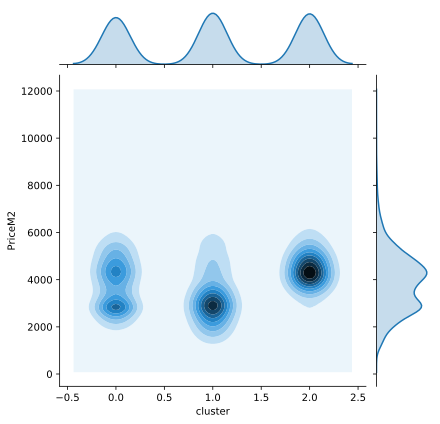

In [17]:
mod_train = scaled_train.copy()
mod_valid = scaled_valid.copy()

# mod_train,mod_valid = normalize_by_price(mod_train, mod_valid, 'Shops_2')

# mod_train.head(10)

# mod_train, mod_valid = drop_column(mod_train, mod_valid, ['Shops_2', 'Ecology_2', 'Ecology_3'])

mod_train, mod_valid, egg = pca_transform(mod_train, mod_valid, 'Ecology_1', ['Ecology_2', 'Ecology_3'])

# mod_train, mod_valid, egg = pca_transform(mod_train, mod_valid, 'DistrictId', ['HouseYear'])

# mod_train, mod_valid = normalize_by_price(mod_train, mod_valid, 'Ecology_1')

CLUSTER_TEST_COUNT = 3

mod_train, mod_valid = set_claster(mod_train, mod_valid, 
                                 ['Social_1', 'Social_3', 'Ecology_1'], CLUSTER_TEST_COUNT)

sns.jointplot(mod_train['cluster'],
              mod_train['PriceM2'], kind='kde');

In [18]:
#Процедура восстанавливает цены в датафрейм для случая оценки по кластерам
#
def add_price_to_frame(df, price, name, cluster):
    
    df = df.copy()
    
    if cluster == 0:
        df[name] = price
        return df
    
    index = 0
    for i in range(cluster):
        
        nexind = index + len(df.loc[df.cluster == i])
        
        df.loc[df.cluster == i, name] = price[index:nexind]
        index = nexind
        
    return df
    

In [19]:
pred_price, egg, spam = random_forest_predict_current(mod_train, mod_valid, WORK_COLUMNS, False, CLUSTER_TEST_COUNT, True)

egg = add_price_to_frame(mod_valid, pred_price, 'PriceNew', CLUSTER_TEST_COUNT)

print("Тест", r2(egg['Price'], egg['PriceNew']) )


АНАЛИЗ / ПРОГНОЗ ЦЕНЫ ЗА МЕТР: False ['DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1', 'Helthcare_2', 'Shops_1', 'Shops_2']
===== сектор 0 =====
{'max_depth': 10, 'min_samples_leaf': 4, 'n_estimators': 100}
      Лучшая оценка регрессии: 0.6586710222244377
      Важность признаков:            columns       ffi
2          Square  0.441512
11       Social_3  0.223635
1           Rooms  0.078014
7       HouseYear  0.038582
4   KitchenSquare  0.032829
3      LifeSquare  0.026997
10       Social_2  0.026140
0      DistrictId  0.019995
5           Floor  0.019572
6      HouseFloor  0.018596
8       Ecology_1  0.017763
9        Social_1  0.016217
12   Healthcare_1  0.015775
14        Shops_1  0.014995
13    Helthcare_2  0.009364
16      Shops_2_B  0.000015
15      Shops_2_A  0.000000
      Оценка предсказания, итер 0 0.7268838491675713
===== сектор 1 ==

# Описание стратегии работы с данными


Стратегии:

1. Оставить как есть
2. Удалить
3. Нормализовать по цене
5. Нормализовать по площади (kitchen, life)
6. Нормализовать по площади, нормализовать по цене (kitchen, life)
7. Нормализовать по этажности (Floor)
8. Нормализовать по этажности, нормализовать по цене (Floor)

9. Кластеризовать, нормализовать по цене

10. Снизить размерность с другими колонками (до 4ех колонок) 
	при рейтинге объединения свыше 0.7, объектные колонки превращаем в числовые и удаляем из таблицы
	объединяем только с последующими колонками
11. Снизить размерность, нормализовать по цене
12. Снизить размерность, кластеризовать, нормализовать по цене

Кластеризация на нижнем уровне: от 2 до всех признаков


In [20]:
import random

STRATEGY_ACTIONS = [
    'None',
    'Drop',
    'NormilizeByPrice',
    'NormilizeBySquare',
    'NormilizeBySquarePrice',
    'NormilizeByFloor',
    'NormilizeByFloorPrice',
    'Cluster',
    'PCA',
    'PCAPrice',
    'PCACluster'
]

MAX_STRATEGY_CLASTERS = 10

def random_columns(count, columns, droped_columns=[], i=None):
    
    result = []
    copy = columns.copy()
    droped = droped_columns.copy()
    
    if not i is None:
        copy.remove(i)
    
    while len(droped):
        if droped[0] in copy:
            copy.remove(droped[0])
        del(droped[0])
        
    while count and len(copy):
        val = random.choice(copy)
        copy.remove(val)
        result.append(val)
        if not len(copy):
            break
        count -= 1
        
    return result
    

def get_strategy():
    
    def add_param(action, droped_columns, i):
    
        if action == 'Cluster':
            return random.randint(2, MAX_STRATEGY_CLASTERS)
        elif action == 'PCA' or action == 'PCAPrice' or action == 'PCACluster':
            columns = random_columns(random.randint(1, 4), WORK_COLUMNS, droped_columns, i)
            droped_columns += columns
            return columns
        
    def add_param2(action):
    
        if action == 'PCACluster':
            return random.randint(2, MAX_STRATEGY_CLASTERS)
        
    
    strategy = {}
    droped_columns = []
    for i in WORK_COLUMNS:
        
        action = None
        while action is None:
            action = random.choice(STRATEGY_ACTIONS)
            if action == 'NormilizeBySquare' or action == 'NormilizeBySquarePrice':
                if not i in ['LifeSquare', 'KitchenSquare']:
                    action = None
            if action == 'NormilizeByFloor' or action == 'NormilizeByFloorPrice':
                if not i in ['Floor']:
                    action = None
            
        strategy[i] = {"action":action}
        if action == 'Drop':
            if len(droped_columns) < len(WORK_COLUMNS) - 3:
                droped_columns.append(i)
            else:
                strategy[i]['action'] = 'None'
        
        
    for i in WORK_COLUMNS:
        
        strategy[i]['add_param1'] = add_param(strategy[i]['action'], droped_columns, i)
        if strategy[i]['add_param1'] == []:
            strategy[i]['action'] = "None"
            
        strategy[i]['add_param2'] = add_param2(strategy[i]['action'])
    
    return strategy
    

In [21]:
get_strategy()

{'DistrictId': {'action': 'Cluster', 'add_param1': 3, 'add_param2': None},
 'Rooms': {'action': 'Drop', 'add_param1': None, 'add_param2': None},
 'Square': {'action': 'PCACluster',
  'add_param1': ['HouseFloor', 'DistrictId', 'Social_2', 'HouseYear'],
  'add_param2': 9},
 'LifeSquare': {'action': 'Drop', 'add_param1': None, 'add_param2': None},
 'KitchenSquare': {'action': 'PCA',
  'add_param1': ['Healthcare_1'],
  'add_param2': None},
 'Floor': {'action': 'NormilizeByPrice',
  'add_param1': None,
  'add_param2': None},
 'HouseFloor': {'action': 'PCACluster',
  'add_param1': ['Shops_2', 'Square', 'Floor'],
  'add_param2': 4},
 'HouseYear': {'action': 'PCACluster',
  'add_param1': ['Ecology_3'],
  'add_param2': 6},
 'Ecology_1': {'action': 'Drop', 'add_param1': None, 'add_param2': None},
 'Ecology_2': {'action': 'PCAPrice',
  'add_param1': ['Helthcare_2', 'Shops_1', 'KitchenSquare', 'Social_3'],
  'add_param2': None},
 'Ecology_3': {'action': 'NormilizeByPrice',
  'add_param1': None,
  

In [22]:
def apply_strategy(strategy, df, vdf):
    
    df = df.copy()
    vdf = vdf.copy()
    
    for col in WORK_COLUMNS:
        
        if not col in df.columns:
            continue
        
        param = strategy[col]
        if param['action'] == 'None':
            continue
            
        elif param['action'] == 'Drop':
            continue
            
        elif param['action'] == 'NormilizeByPrice':
            df, vdf = normalize_by_price(df, vdf, col)
        
        elif param['action'] == 'NormilizeBySquare':
            df, vdf = normalize_by_name(df, vdf, col, 'Square')
        
        elif param['action'] == 'NormilizeBySquarePrice':
            df, vdf = normalize_by_name(df, vdf, col, 'Square')
            df, vdf = normalize_by_price(df, vdf, col)
        
        elif param['action'] == 'NormilizeByFloor':
            df, vdf = normalize_by_name(df, vdf, col, 'HouseFloor')

        elif param['action'] == 'NormilizeByFloorPrice':
            df, vdf = normalize_by_name(df, vdf, col, 'HouseFloor')
            df, vdf = normalize_by_price(df, vdf, col)

        elif param['action'] == 'Cluster':
            df, vdf = claster_normilized_by_price(df, vdf, col, param['add_param1'])

        elif param['action'] == 'PCA':
            egg, spam, ratio = pca_transform(df, vdf, col, param['add_param1'])
            if ratio > 0.6:
                df = egg
                vdf = spam

        elif param['action'] == 'PCAPrice':
            egg, spam, ratio = pca_transform(df, vdf, col, param['add_param1'])
            if ratio > 0.6:
                df, vdf = normalize_by_price(egg, spam, col)
               
        elif param['action'] == 'PCACluster':
            egg, spam, ratio = pca_transform(df, vdf, col, param['add_param1'])
            if ratio > 0.6:
                df, vdf = claster_normilized_by_price(egg, spam, col, param['add_param2'])
            
        else:
            print("Неизвестные параметры", param)
            
    for col in WORK_COLUMNS:
        
        param = strategy[col]
        if param['action'] == 'Drop':
            df, vdf = drop_column(df, vdf, col)
     
    
    return df, vdf

In [23]:
strategy = get_strategy()
print(strategy)
print(scaled_train.columns)
df, vdf = apply_strategy(strategy, scaled_train, scaled_valid)

random_forest_predict_current(df, vdf, WORK_COLUMNS, False, 0, True)

{'DistrictId': {'action': 'Drop', 'add_param1': None, 'add_param2': None}, 'Rooms': {'action': 'NormilizeByPrice', 'add_param1': None, 'add_param2': None}, 'Square': {'action': 'PCAPrice', 'add_param1': ['Ecology_1', 'Rooms', 'Social_1'], 'add_param2': None}, 'LifeSquare': {'action': 'Drop', 'add_param1': None, 'add_param2': None}, 'KitchenSquare': {'action': 'Drop', 'add_param1': None, 'add_param2': None}, 'Floor': {'action': 'PCACluster', 'add_param1': ['Shops_2', 'Helthcare_2', 'Square', 'Ecology_3'], 'add_param2': 10}, 'HouseFloor': {'action': 'Drop', 'add_param1': None, 'add_param2': None}, 'HouseYear': {'action': 'PCA', 'add_param1': ['Shops_1'], 'add_param2': None}, 'Ecology_1': {'action': 'Cluster', 'add_param1': 3, 'add_param2': None}, 'Ecology_2': {'action': 'None', 'add_param1': None, 'add_param2': None}, 'Ecology_3': {'action': 'Cluster', 'add_param1': 6, 'add_param2': None}, 'Social_1': {'action': 'PCA', 'add_param1': ['Social_3'], 'add_param2': None}, 'Social_2': {'action

(array([274904.89670361, 244588.27972701, 186614.34804003, ...,
        168080.07670434, 127948.03819366, 200185.96197652]),
 0.6966888540633753,
 None)

# Сделаем модель, которая найдет оптимальную модель

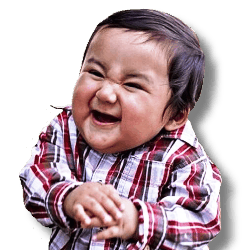

In [26]:
from datetime import datetime

resultP = [[0, 0, 0, 0, 0]] * 3
resultM2 = [[0, 0, 0, 0, 0]] * 3

COUNT_STRAT = 198
lochash = []

def exec_strategy(df, vdf, strategy, result, PriceM2):
    
    cluster = 0
    useclus = []
    rand_columns = []
    
    isgoodresult = False
    
    for _ in range(5):
        
        df = df.copy()
        vdf = vdf.copy()
    
        price, egg, spam = random_forest_predict_current(df, vdf, WORK_COLUMNS, PriceM2, cluster, False)

        if result[2][1] < egg:
        
            del(result[0])
            
            result.append([strategy, egg, spam, rand_columns, cluster])
            print("="*8, "by M2:", PriceM2, "="*8)
            print(strategy)
            print("Колонки кластера", rand_columns, "Количество кластеров", cluster)
            print("Лучшее решение:", egg)
            
            isgoodresult = True
        
        #Если попробовали с кластером и все равно не было улучшения - закрываем 
        #попытку по стратегии
        elif cluster != 0 and isgoodresult == False:
            break
        
        cluster = random.randint(2, MAX_STRATEGY_CLASTERS)
        while cluster in useclus:
            cluster = random.randint(2, MAX_STRATEGY_CLASTERS)
        
        rand_columns = [i for i in WORK_COLUMNS if i in df.columns]
        rand_columns = random_columns(random.randint(2, min(len(df.columns) - 1, 8)), rand_columns)

        df, vdf = set_claster(df, vdf, rand_columns, cluster)
        
        useclus.append(cluster)
    
i = 0
mean_time = []
while i <= COUNT_STRAT:
    
    strategy = get_strategy()
    if strategy in lochash:
        continue
        
    lochash.append(strategy)
    
    timestamp = datetime.now()
    
    try:
        df, vdf = apply_strategy(strategy, scaled_train, scaled_valid)
    except Exception as e:
        print("Ошибка Apply strategy:", e)
        continue

    try:
        exec_strategy(df, vdf, strategy, resultP, False)
    except Exception as e:
        print("Ошибка выполнения Price:", e)
        
    try:
        exec_strategy(df, vdf, strategy, resultM2, True)
    except Exception as e:
        print("Ошибка выполнения M2:", e)
        
    timestamp = (datetime.now() - timestamp).seconds
    mean_time.append(timestamp)
    print("Вариант", i, "время обработки", timestamp, "Среднее время обработки", sum(mean_time) / len(mean_time))
    
    i += 1
    


Вариант 0 время обработки 60 Среднее время обработки 60.0
======== by M2: False ========
{'DistrictId': {'action': 'Drop', 'add_param1': None, 'add_param2': None}, 'Rooms': {'action': 'NormilizeByPrice', 'add_param1': None, 'add_param2': None}, 'Square': {'action': 'Cluster', 'add_param1': 2, 'add_param2': None}, 'LifeSquare': {'action': 'Drop', 'add_param1': None, 'add_param2': None}, 'KitchenSquare': {'action': 'NormilizeBySquare', 'add_param1': None, 'add_param2': None}, 'Floor': {'action': 'NormilizeByFloorPrice', 'add_param1': None, 'add_param2': None}, 'HouseFloor': {'action': 'None', 'add_param1': None, 'add_param2': None}, 'HouseYear': {'action': 'NormilizeByPrice', 'add_param1': None, 'add_param2': None}, 'Ecology_1': {'action': 'NormilizeByPrice', 'add_param1': None, 'add_param2': None}, 'Ecology_2': {'action': 'Drop', 'add_param1': None, 'add_param2': None}, 'Ecology_3': {'action': 'PCACluster', 'add_param1': ['KitchenSquare', 'HouseFloor'], 'add_param2': 6}, 'Social_1': {'a

Вариант 3 время обработки 173 Среднее время обработки 112.5
Вариант 4 время обработки 61 Среднее время обработки 102.2
Вариант 5 время обработки 78 Среднее время обработки 98.16666666666667
Вариант 6 время обработки 49 Среднее время обработки 91.14285714285714
Вариант 7 время обработки 62 Среднее время обработки 87.5
======== by M2: False ========
{'DistrictId': {'action': 'PCA', 'add_param1': ['Shops_1', 'Ecology_1', 'Ecology_2'], 'add_param2': None}, 'Rooms': {'action': 'PCA', 'add_param1': ['Ecology_3', 'Shops_2', 'Social_3', 'Social_2'], 'add_param2': None}, 'Square': {'action': 'Drop', 'add_param1': None, 'add_param2': None}, 'LifeSquare': {'action': 'PCA', 'add_param1': ['Helthcare_2'], 'add_param2': None}, 'KitchenSquare': {'action': 'Cluster', 'add_param1': 7, 'add_param2': None}, 'Floor': {'action': 'Drop', 'add_param1': None, 'add_param2': None}, 'HouseFloor': {'action': 'Drop', 'add_param1': None, 'add_param2': None}, 'HouseYear': {'action': 'NormilizeByPrice', 'add_param1':

======== by M2: True ========
{'DistrictId': {'action': 'Cluster', 'add_param1': 10, 'add_param2': None}, 'Rooms': {'action': 'PCA', 'add_param1': ['Social_1', 'Shops_1', 'Social_3'], 'add_param2': None}, 'Square': {'action': 'Cluster', 'add_param1': 10, 'add_param2': None}, 'LifeSquare': {'action': 'Cluster', 'add_param1': 10, 'add_param2': None}, 'KitchenSquare': {'action': 'Cluster', 'add_param1': 6, 'add_param2': None}, 'Floor': {'action': 'Cluster', 'add_param1': 3, 'add_param2': None}, 'HouseFloor': {'action': 'PCACluster', 'add_param1': ['Ecology_2'], 'add_param2': 6}, 'HouseYear': {'action': 'NormilizeByPrice', 'add_param1': None, 'add_param2': None}, 'Ecology_1': {'action': 'NormilizeByPrice', 'add_param1': None, 'add_param2': None}, 'Ecology_2': {'action': 'NormilizeByPrice', 'add_param1': None, 'add_param2': None}, 'Ecology_3': {'action': 'PCACluster', 'add_param1': ['Helthcare_2', 'Rooms'], 'add_param2': 3}, 'Social_1': {'action': 'NormilizeByPrice', 'add_param1': None, 'ad

Вариант 34 время обработки 121 Среднее время обработки 70.97142857142858
Вариант 35 время обработки 56 Среднее время обработки 70.55555555555556
Вариант 36 время обработки 46 Среднее время обработки 69.89189189189189
Вариант 37 время обработки 36 Среднее время обработки 69.0
======== by M2: True ========
{'DistrictId': {'action': 'PCACluster', 'add_param1': ['HouseYear', 'Square', 'KitchenSquare'], 'add_param2': 8}, 'Rooms': {'action': 'PCA', 'add_param1': ['Floor', 'Helthcare_2'], 'add_param2': None}, 'Square': {'action': 'None', 'add_param1': None, 'add_param2': None}, 'LifeSquare': {'action': 'Cluster', 'add_param1': 3, 'add_param2': None}, 'KitchenSquare': {'action': 'None', 'add_param1': None, 'add_param2': None}, 'Floor': {'action': 'PCAPrice', 'add_param1': ['DistrictId', 'Shops_1'], 'add_param2': None}, 'HouseFloor': {'action': 'PCAPrice', 'add_param1': ['Social_1', 'Social_2', 'Social_3', 'Ecology_1'], 'add_param2': None}, 'HouseYear': {'action': 'PCACluster', 'add_param1': ['

======== by M2: False ========
{'DistrictId': {'action': 'NormilizeByPrice', 'add_param1': None, 'add_param2': None}, 'Rooms': {'action': 'PCACluster', 'add_param1': ['KitchenSquare', 'Shops_1'], 'add_param2': 7}, 'Square': {'action': 'PCA', 'add_param1': ['Shops_2'], 'add_param2': None}, 'LifeSquare': {'action': 'Cluster', 'add_param1': 5, 'add_param2': None}, 'KitchenSquare': {'action': 'NormilizeBySquare', 'add_param1': None, 'add_param2': None}, 'Floor': {'action': 'NormilizeByFloor', 'add_param1': None, 'add_param2': None}, 'HouseFloor': {'action': 'PCA', 'add_param1': ['Ecology_1', 'Square', 'Social_2', 'Social_3'], 'add_param2': None}, 'HouseYear': {'action': 'None', 'add_param1': None, 'add_param2': None}, 'Ecology_1': {'action': 'None', 'add_param1': None, 'add_param2': None}, 'Ecology_2': {'action': 'NormilizeByPrice', 'add_param1': None, 'add_param2': None}, 'Ecology_3': {'action': 'None', 'add_param1': None, 'add_param2': None}, 'Social_1': {'action': 'Drop', 'add_param1': 

Вариант 141 время обработки 52 Среднее время обработки 56.683098591549296
Вариант 142 время обработки 44 Среднее время обработки 56.59440559440559
Вариант 143 время обработки 46 Среднее время обработки 56.520833333333336
Вариант 144 время обработки 63 Среднее время обработки 56.56551724137931
Вариант 145 время обработки 42 Среднее время обработки 56.465753424657535
Вариант 146 время обработки 51 Среднее время обработки 56.42857142857143
Вариант 147 время обработки 51 Среднее время обработки 56.391891891891895
Вариант 148 время обработки 45 Среднее время обработки 56.31543624161074
Вариант 149 время обработки 44 Среднее время обработки 56.233333333333334
Вариант 150 время обработки 54 Среднее время обработки 56.21854304635762
Вариант 151 время обработки 58 Среднее время обработки 56.23026315789474
Вариант 152 время обработки 41 Среднее время обработки 56.130718954248366
Вариант 153 время обработки 48 Среднее время обработки 56.077922077922075
Вариант 154 время обработки 54 Среднее время

{'DistrictId': {'action': 'NormilizeByPrice', 'add_param1': None, 'add_param2': None}, 'Rooms': {'action': 'None', 'add_param1': None, 'add_param2': None}, 'Square': {'action': 'None', 'add_param1': None, 'add_param2': None}, 'LifeSquare': {'action': 'PCAPrice', 'add_param1': ['KitchenSquare', 'Ecology_3', 'DistrictId', 'Social_3'], 'add_param2': None}, 'KitchenSquare': {'action': 'PCA', 'add_param1': ['HouseYear'], 'add_param2': None}, 'Floor': {'action': 'PCA', 'add_param1': ['Shops_2', 'Rooms', 'LifeSquare'], 'add_param2': None}, 'HouseFloor': {'action': 'None', 'add_param1': None, 'add_param2': None}, 'HouseYear': {'action': 'PCACluster', 'add_param1': ['HouseFloor', 'Shops_1', 'Square'], 'add_param2': 7}, 'Ecology_1': {'action': 'Drop', 'add_param1': None, 'add_param2': None}, 'Ecology_2': {'action': 'Drop', 'add_param1': None, 'add_param2': None}, 'Ecology_3': {'action': 'PCA', 'add_param1': ['Social_2'], 'add_param2': None}, 'Social_1': {'action': 'Drop', 'add_param1': None, 'add_param2': None}, 'Social_2': {'action': 'PCACluster', 'add_param1': ['Floor'], 'add_param2': 7}, 'Social_3': {'action': 'None', 'add_param1': [], 'add_param2': None}, 'Healthcare_1': {'action': 'Drop', 'add_param1': None, 'add_param2': None}, 'Helthcare_2': {'action': 'Drop', 'add_param1': None, 'add_param2': None}, 'Shops_1': {'action': 'None', 'add_param1': [], 'add_param2': None}, 'Shops_2': {'action': 'None', 'add_param1': [], 'add_param2': None}}
Колонки кластера [] Количество кластеров 0
Лучшее решение: 0.7673639881864445

======== by M2: False ========
{'DistrictId': {'action': 'NormilizeByPrice', 'add_param1': None, 'add_param2': None}, 'Rooms': {'action': 'NormilizeByPrice', 'add_param1': None, 'add_param2': None}, 'Square': {'action': 'None', 'add_param1': None, 'add_param2': None}, 'LifeSquare': {'action': 'None', 'add_param1': None, 'add_param2': None}, 'KitchenSquare': {'action': 'PCA', 'add_param1': ['Rooms', 'LifeSquare'], 'add_param2': None}, 'Floor': {'action': 'NormilizeByPrice', 'add_param1': None, 'add_param2': None}, 'HouseFloor': {'action': 'None', 'add_param1': None, 'add_param2': None}, 'HouseYear': {'action': 'PCA', 'add_param1': ['Social_3'], 'add_param2': None}, 'Ecology_1': {'action': 'Cluster', 'add_param1': 6, 'add_param2': None}, 'Ecology_2': {'action': 'None', 'add_param1': None, 'add_param2': None}, 'Ecology_3': {'action': 'PCAPrice', 'add_param1': ['Floor', 'Social_1'], 'add_param2': None}, 'Social_1': {'action': 'PCACluster', 'add_param1': ['KitchenSquare', 'Square', 'Shops_2', 'Helthcare_2'], 'add_param2': 8}, 'Social_2': {'action': 'Cluster', 'add_param1': 9, 'add_param2': None}, 'Social_3': {'action': 'None', 'add_param1': None, 'add_param2': None}, 'Healthcare_1': {'action': 'NormilizeByPrice', 'add_param1': None, 'add_param2': None}, 'Helthcare_2': {'action': 'PCA', 'add_param1': ['Shops_1', 'Healthcare_1', 'HouseFloor'], 'add_param2': None}, 'Shops_1': {'action': 'PCA', 'add_param1': ['Social_2', 'DistrictId'], 'add_param2': None}, 'Shops_2': {'action': 'NormilizeByPrice', 'add_param1': None, 'add_param2': None}}
Колонки кластера ['Square', 'Healthcare_1', 'Shops_1', 'Social_1'] Количество кластеров 2
Лучшее решение: 0.7626455473188098

ЛУЧШИЕ СТРАТЕГИИ
======== by M2: False ========
{'DistrictId': {'action': 'NormilizeByPrice', 'add_param1': None, 'add_param2': None}, 'Rooms': {'action': 'PCACluster', 'add_param1': ['KitchenSquare', 'Shops_1'], 'add_param2': 7}, 'Square': {'action': 'PCA', 'add_param1': ['Shops_2'], 'add_param2': None}, 'LifeSquare': {'action': 'Cluster', 'add_param1': 5, 'add_param2': None}, 'KitchenSquare': {'action': 'NormilizeBySquare', 'add_param1': None, 'add_param2': None}, 'Floor': {'action': 'NormilizeByFloor', 'add_param1': None, 'add_param2': None}, 'HouseFloor': {'action': 'PCA', 'add_param1': ['Ecology_1', 'Square', 'Social_2', 'Social_3'], 'add_param2': None}, 'HouseYear': {'action': 'None', 'add_param1': None, 'add_param2': None}, 'Ecology_1': {'action': 'None', 'add_param1': None, 'add_param2': None}, 'Ecology_2': {'action': 'NormilizeByPrice', 'add_param1': None, 'add_param2': None}, 'Ecology_3': {'action': 'None', 'add_param1': None, 'add_param2': None}, 'Social_1': {'action': 'Drop', 'add_param1': None, 'add_param2': None}, 'Social_2': {'action': 'NormilizeByPrice', 'add_param1': None, 'add_param2': None}, 'Social_3': {'action': 'PCACluster', 'add_param1': ['HouseYear'], 'add_param2': 5}, 'Healthcare_1': {'action': 'Cluster', 'add_param1': 4, 'add_param2': None}, 'Helthcare_2': {'action': 'NormilizeByPrice', 'add_param1': None, 'add_param2': None}, 'Shops_1': {'action': 'NormilizeByPrice', 'add_param1': None, 'add_param2': None}, 'Shops_2': {'action': 'Cluster', 'add_param1': 7, 'add_param2': None}}
Колонки кластера ['Ecology_2', 'Social_3', 'HouseYear', 'Square'] Количество кластеров 8
Лучшее решение: 0.7648858669136599
    
======== by M2: True ========
{'DistrictId': {'action': 'PCACluster', 'add_param1': ['HouseYear', 'Square', 'KitchenSquare'], 'add_param2': 8}, 'Rooms': {'action': 'PCA', 'add_param1': ['Floor', 'Helthcare_2'], 'add_param2': None}, 'Square': {'action': 'None', 'add_param1': None, 'add_param2': None}, 'LifeSquare': {'action': 'Cluster', 'add_param1': 3, 'add_param2': None}, 'KitchenSquare': {'action': 'None', 'add_param1': None, 'add_param2': None}, 'Floor': {'action': 'PCAPrice', 'add_param1': ['DistrictId', 'Shops_1'], 'add_param2': None}, 'HouseFloor': {'action': 'PCAPrice', 'add_param1': ['Social_1', 'Social_2', 'Social_3', 'Ecology_1'], 'add_param2': None}, 'HouseYear': {'action': 'PCACluster', 'add_param1': ['Ecology_3', 'Healthcare_1', 'Shops_2'], 'add_param2': 2}, 'Ecology_1': {'action': 'NormilizeByPrice', 'add_param1': None, 'add_param2': None}, 'Ecology_2': {'action': 'Drop', 'add_param1': None, 'add_param2': None}, 'Ecology_3': {'action': 'PCA', 'add_param1': ['LifeSquare'], 'add_param2': None}, 'Social_1': {'action': 'None', 'add_param1': None, 'add_param2': None}, 'Social_2': {'action': 'None', 'add_param1': None, 'add_param2': None}, 'Social_3': {'action': 'PCA', 'add_param1': ['HouseFloor'], 'add_param2': None}, 'Healthcare_1': {'action': 'PCA', 'add_param1': ['Rooms'], 'add_param2': None}, 'Helthcare_2': {'action': 'Cluster', 'add_param1': 9, 'add_param2': None}, 'Shops_1': {'action': 'None', 'add_param1': None, 'add_param2': None}, 'Shops_2': {'action': 'None', 'add_param1': [], 'add_param2': None}}
Колонки кластера ['Square', 'Social_3', 'DistrictId', 'HouseYear', 'Shops_1', 'Social_2', 'Ecology_3', 'Shops_2'] Количество кластеров 4
Лучшее решение: 0.7716106240249495    

    


In [173]:
def check_other_rs(df, vdf, result, byPrice, listRS):
    
    df, vdf = apply_strategy(result[2][0], df, vdf)
    
    print("="*8, "by Price", byPrice, "="*8)
    
    print(result[2][1],result[2][3],result[2][4])

    if result[2][4] > 0:
        df, vdf = set_claster(df, vdf, result[2][3], result[2][4])

    test = []
    
    for i in listRS:
        
        price, egg, spam = random_forest_predict_current(df, vdf, WORK_COLUMNS, byPrice, result[2][4], False, r_state=i)
        egg_table = add_price_to_frame(vdf, price, 'PriceNew', result[2][4])        
        
        test.append([i, egg, spam, 'TEST', r2(egg_table['Price'], egg_table['PriceNew'])])
    
    print(result[2][1])
    for i in test:
        print(i)

In [55]:
#Проверим повторимость результата c другими random_state на тех же данных

listRS = [44]
for i in range(4):
    listRS.append(random.randint(1, 100))
    
check_other_rs(df, vdf, resultP, False, listRS)

check_other_rs(df, vdf, resultM2, True, listRS)


======== by Price False ========
0.7648858669136599 ['Ecology_2', 'Social_3', 'HouseYear', 'Square'] 8
0.7648858669136599
[44, 0.764479790388974, None, 'TEST', 0.764479790388974]
[16, 0.761473912309319, None, 'TEST', 0.7614739123093189]
[22, 0.7631888436492955, None, 'TEST', 0.7631888436492955]
[48, 0.7625772180043908, None, 'TEST', 0.7625772180043907]
[18, 0.7642755238370704, None, 'TEST', 0.7642755238370703]
======== by Price True ========
0.7716106240249495 ['Square', 'Social_3', 'DistrictId', 'HouseYear', 'Shops_1', 'Social_2', 'Ecology_3', 'Shops_2'] 4
0.7716106240249495
[44, 0.7716106240249495, 0.661884249527515, 'TEST', 0.7716106240249495]
[16, 0.7681909647460605, 0.6556052853295808, 'TEST', 0.7681909647460605]
[22, 0.7727025455727022, 0.6617963534024638, 'TEST', 0.7727025455727022]
[48, 0.772412341099952, 0.6585012154753074, 'TEST', 0.772412341099952]
[18, 0.7712068161842669, 0.660494411744957, 'TEST', 0.7712068161842669]


In [134]:
#Проверим что при повторном выполнении всех модификаций получим тот же результат
def get_finaly_data(df, vdf):
    
    df, vdf = ClearData(df, vdf)   

    df = save_columns(df)
    vdf = save_columns(vdf)
    
    scale_columns = [i for i in WORK_COLUMNS if not df[i].dtype == np.dtype('O')]    
    df.loc[:,scale_columns], vdf.loc[:,scale_columns] = scale_data(df, vdf, scale_columns)
    
    return df, vdf
    

In [172]:
df, vdf = train_test_split(data, test_size=0.3, random_state = MAIN_DATA_RANDOM_STATE)

df, vdf = get_finaly_data(df, vdf)

listRS = [44]

#Проверим воспроизводимость результата при повторной обработке
check_other_rs(df, vdf, resultP, False, listRS)

check_other_rs(df, vdf, resultM2, True, listRS)



======== by Price False ========
0.7648858669136599 ['Ecology_2', 'Social_3', 'HouseYear', 'Square'] 8
0.7648858669136599
[44, 0.764479790388974, None, 'TEST', 0.764479790388974]
======== by Price True ========
0.7716106240249495 ['Square', 'Social_3', 'DistrictId', 'HouseYear', 'Shops_1', 'Social_2', 'Ecology_3', 'Shops_2'] 4
0.7716106240249495
[44, 0.7716106240249495, 0.661884249527515, 'TEST', 0.7716106240249495]


In [74]:
#Проверим воспроизводимость результата при других выборках
#Воспроизведен норм, данные отображаемые - проверки. Перезапускать не стал, мало времени до сдачи куровика.
for i in range(5):
    
    rs_loc = random.randint(1, 100)
    print(rs_loc)
  
    df, vdf = train_test_split(data, test_size=0.3, random_state = rs_loc)

    df, vdf = get_finaly_data(df, vdf)

    check_other_rs(df, vdf, resultP, False, listRS)

    check_other_rs(df, vdf, resultM2, True, listRS)
    


76
9970     1612
8922     1531
2110    13026
7504     5804
5090    15783
Name: Id, dtype: int64
5469     8419
1847    13774
6927    15794
2843     8666
7845    12646
Name: Id, dtype: int64
75
7148     8112
347        80
3554    16583
8224    14569
2702    15894
Name: Id, dtype: int64
8747    16673
3695     7878
8717     7068
8634    11868
8955    10812
Name: Id, dtype: int64
88
5125      115
7975     6034
206     12352
5632     8056
6558     9016
Name: Id, dtype: int64
6312    11401
4425    12741
9876     1975
9637     8959
3233    13645
Name: Id, dtype: int64
35
4806    14364
3722    16212
8833    11869
2799    11743
2561     7599
Name: Id, dtype: int64
6656     6565
1656     7454
5172     5811
5961     4525
4138    12358
Name: Id, dtype: int64
65
6541     9968
8385     6801
5127    11619
5256       11
8093    10408
Name: Id, dtype: int64
4876     4167
9340    15129
984     11921
4202    10043
5745     5911
Name: Id, dtype: int64


In [176]:
df, vdf = train_test_split(data, test_size=0.3, random_state = 44)
  
df, vdf = get_finaly_data(df, vdf)

check_other_rs(df, vdf, resultM2, True, [44])

# price = vdf['Price']
    
# vdf.drop('Price', axis =1, inplace=True)

df, vdf = apply_strategy(resultM2[2][0], df, vdf)
    
if resultM2[2][4] > 0:
    df, vdf = set_claster(df, vdf, resultM2[2][3], resultM2[2][4])

price_final, egg, egg1 = random_forest_predict_current(df, vdf, WORK_COLUMNS, True, resultM2[2][4], False)

print(egg)

vdf = add_price_to_frame(vdf, price_final, 'PriceNew', resultM2[2][4])        

r2(vdf['Price'], vdf['PriceNew'])


======== by Price True ========
0.7716106240249495 ['Square', 'Social_3', 'DistrictId', 'HouseYear', 'Shops_1', 'Social_2', 'Ecology_3', 'Shops_2'] 4
0.7716106240249495
[44, 0.7490377659334386, 0.6410515479674239, 'TEST', 0.7490377659334386]
0.7490377659334386


0.7490377659334386

In [179]:
df, vdf = get_finaly_data(data, test_main_data)

df, vdf = apply_strategy(resultM2[2][0], df, vdf)
    
if resultM2[2][4] > 0:
    df, vdf = set_claster(df, vdf, resultM2[2][3], resultM2[2][4])

price_final = random_forest_predict_current(df, vdf, WORK_COLUMNS, True, resultM2[2][4], False, 
                                            r_state=MAIN_DATA_RANDOM_STATE, finaly=True)

vdf = pd.DataFrame(vdf.loc[:,['Id', 'cluster']])

result = add_price_to_frame(vdf, price_final, 'Price', resultM2[2][4])        
result = result[['Id', 'Price']]

result.to_csv('SNaumov_predictions.csv', index=None)

result

,Id,Price
0,725,1.635887e+05
1,15856,2.319662e+05
2,5480,5.707333e+08
3,15664,3.103811e+05
4,14275,1.528075e+05
5,7633,1.963787e+05
6,13329,1.712854e+05
7,5502,2.321426e+05
8,4220,2.824405e+05
9,11538,2.124661e+05
